In [4]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from src.attention_analysis import AttentionAnalyzer

In [5]:
# Инициализация анализатора
analyzer = AttentionAnalyzer('../models/vit-fashion-mnist-fast/')

In [6]:
# Загрузка тестовых изображений
dataset = load_dataset("fashion_mnist")
test_images = dataset['test']['image'][:10]  # Первые 10 изображений
test_labels = dataset['test']['label'][:10]

label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [7]:
# Анализ для первого изображения
image_idx = 0
image = test_images[image_idx]
true_label = label_names[test_labels[image_idx]]

print(f"Анализ изображения: {true_label}")

Анализ изображения: Ankle boot


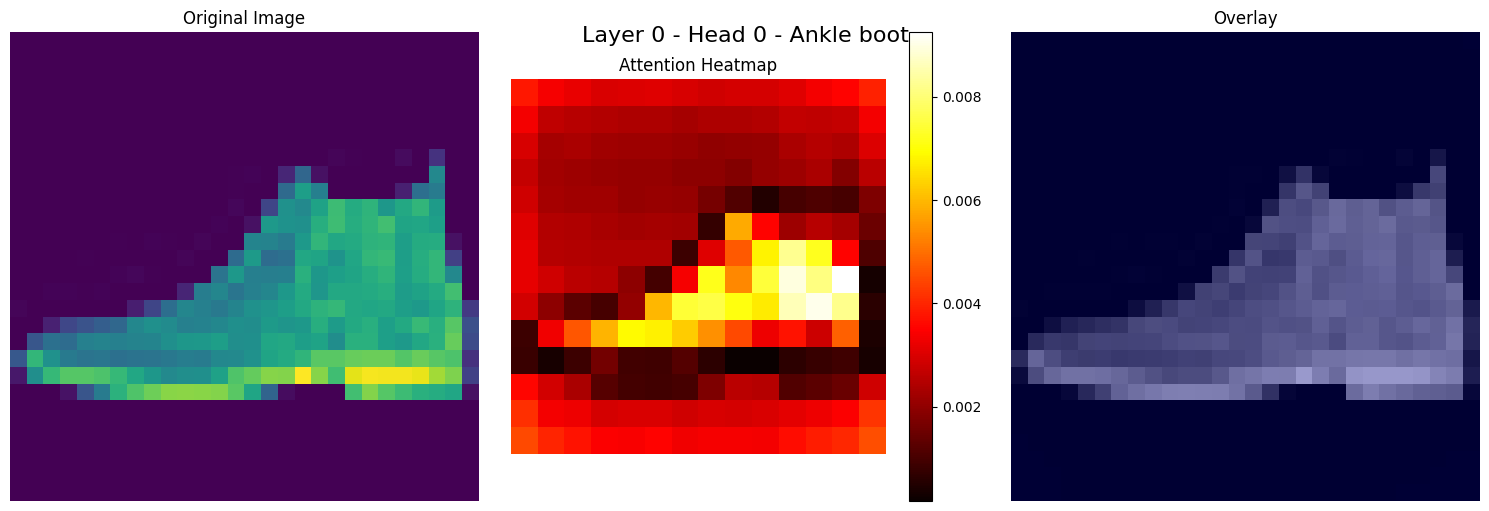

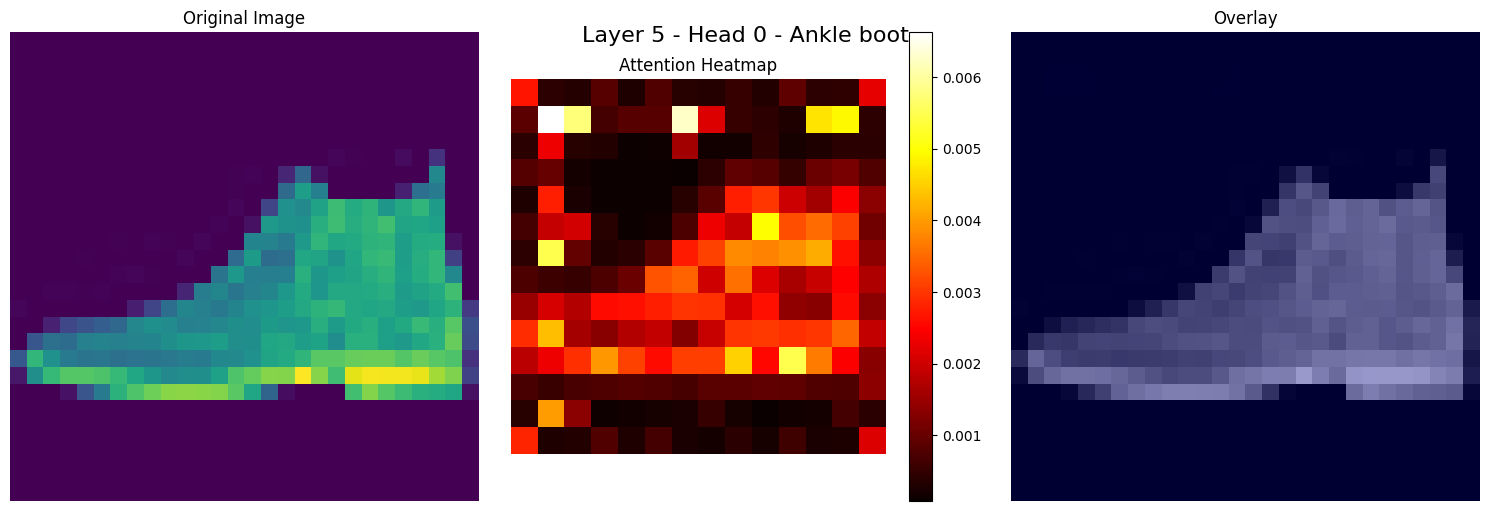

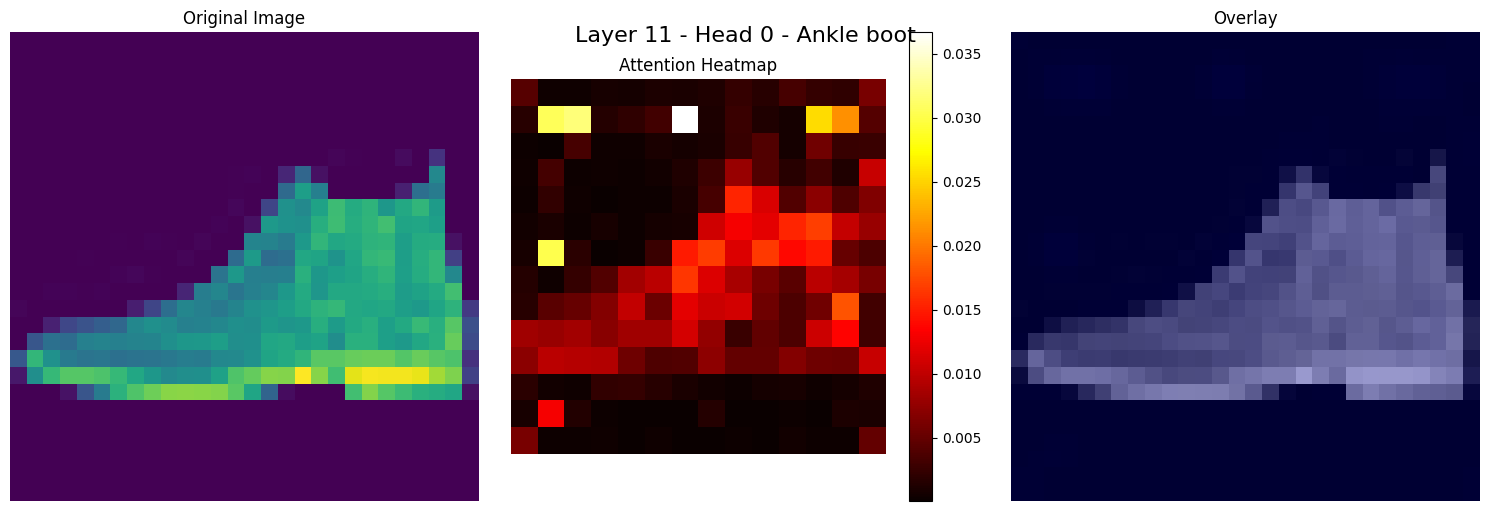

In [8]:
# Визуализация для разных слоев
for layer in [0, 5, 11]:
    fig = analyzer.visualize_cls_attention(image, layer_idx=layer, head_idx=0)
    fig.suptitle(f'Layer {layer} - Head 0 - {true_label}', fontsize=16)
    plt.show()

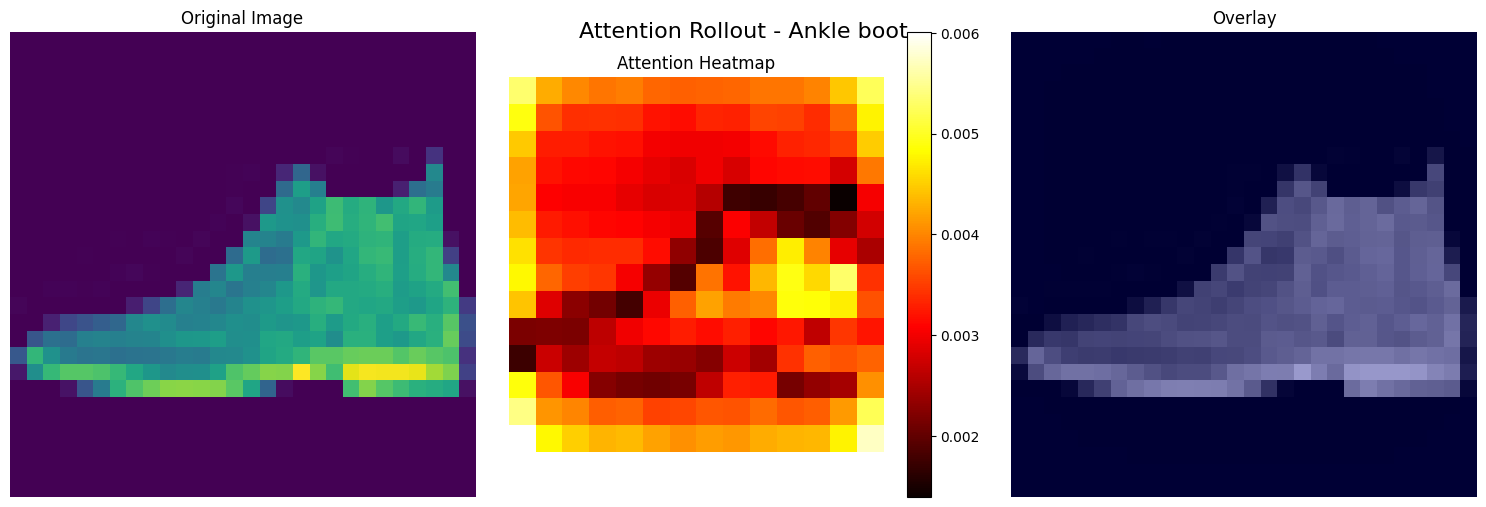

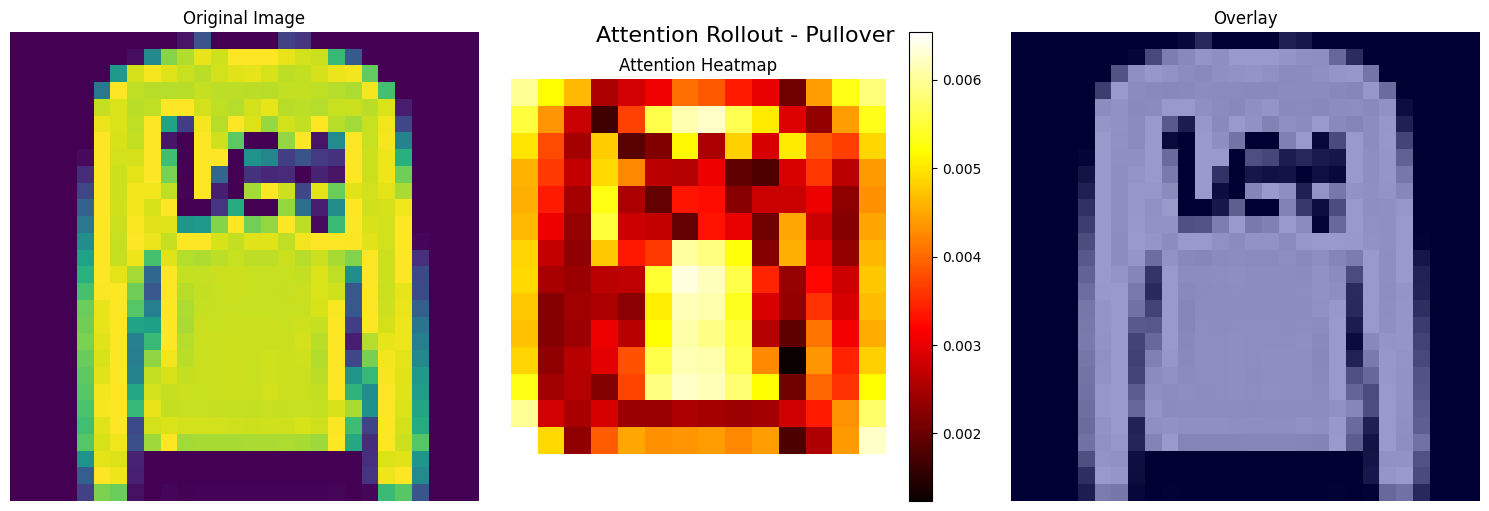

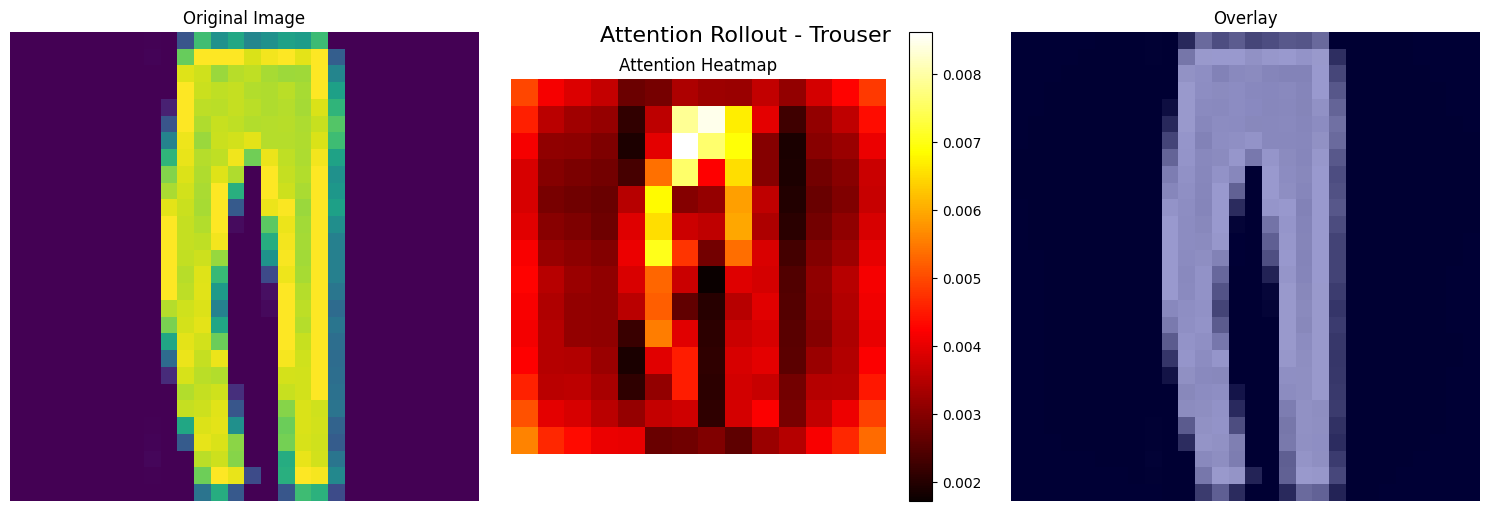

In [6]:
# Attention Rollout для нескольких изображений
for i in range(3):
    image = test_images[i]
    true_label = label_names[test_labels[i]]
    
    fig = analyzer.attention_rollout(image)
    fig.suptitle(f'Attention Rollout - {true_label}', fontsize=16)
    plt.show()


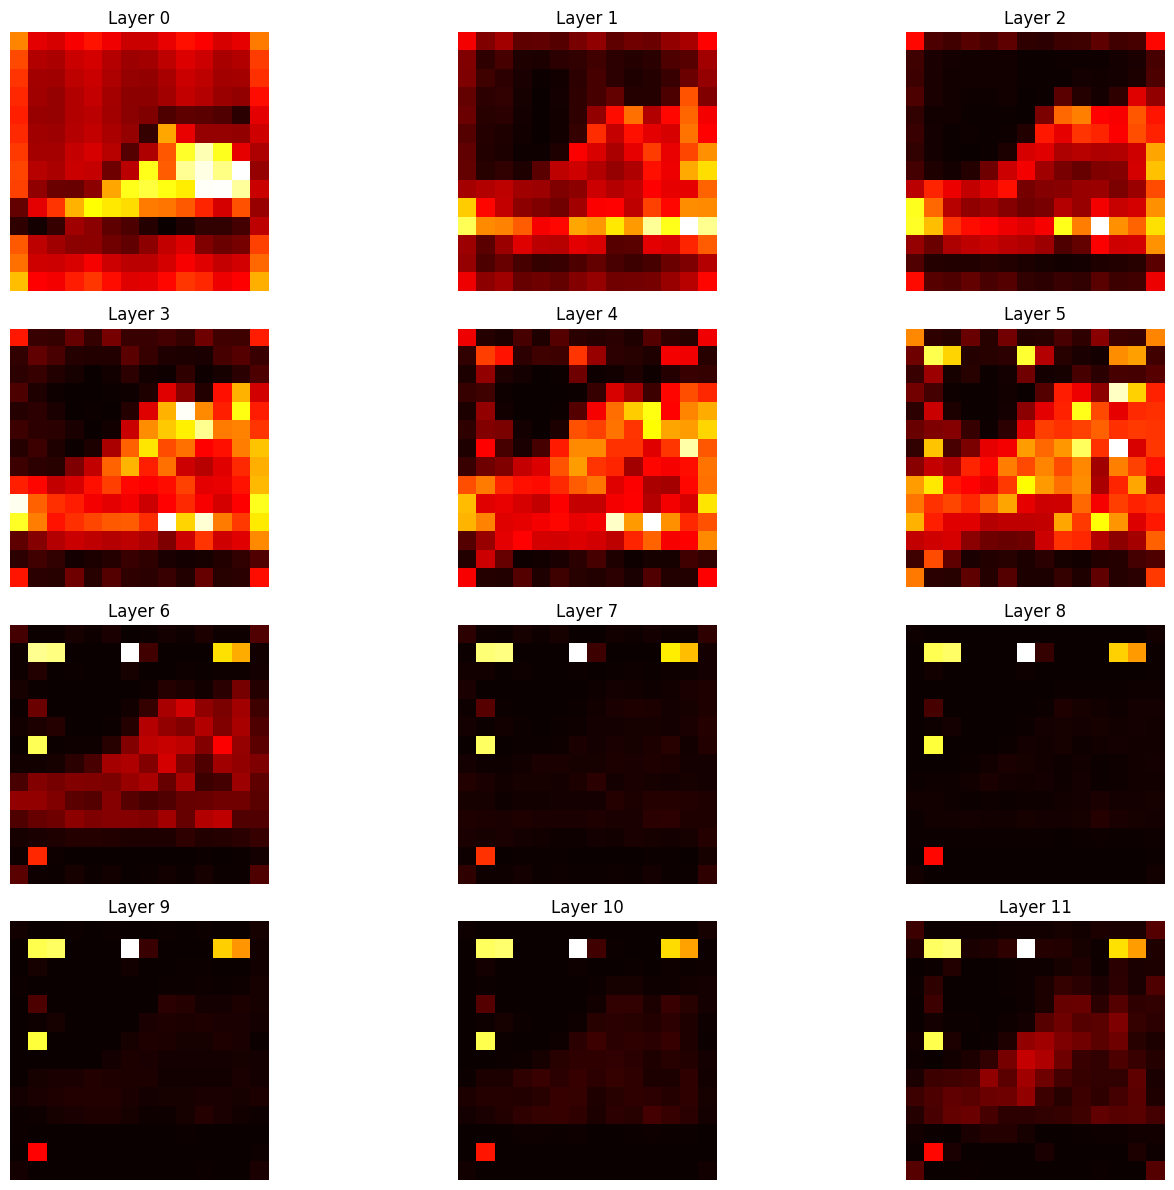

In [8]:
# Сравнение attention по слоям для одного изображения
analyzer.compare_heads_layers(
    test_images[0], 
    save_path='../reports/attention_visualizations/layers_comparison.png'
)

In [9]:
# Анализ разнообразия attention heads
diversity_scores = analyzer.analyze_head_diversity(test_images[0])

print("Разнообразие attention heads по слоям:")
for layer, diversity in diversity_scores:
    print(f"Layer {layer}: {diversity:.3f}")

Разнообразие attention heads по слоям:
Layer 0: 0.329
Layer 1: 0.239
Layer 2: 0.193
Layer 3: 0.094
Layer 4: 0.247
Layer 5: 0.306
Layer 6: 0.284
Layer 7: 0.037
Layer 8: 0.008
Layer 9: 0.014
Layer 10: 0.043
Layer 11: 0.094


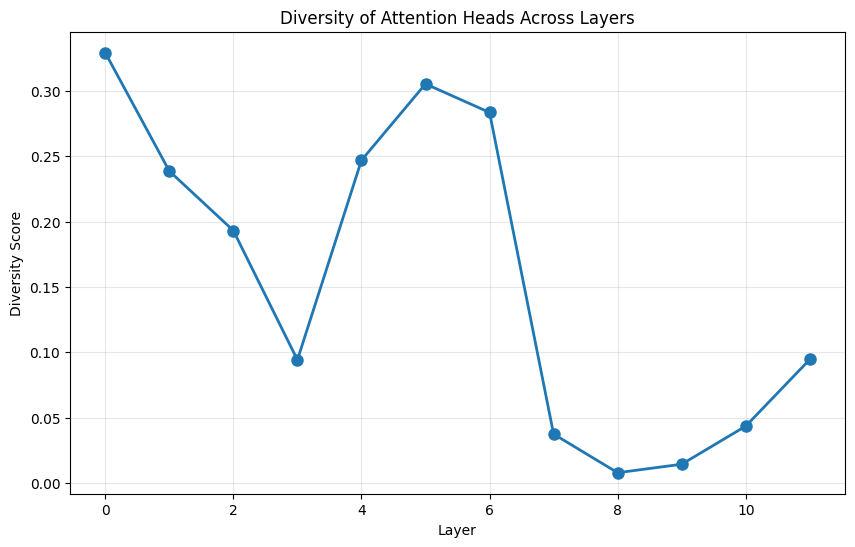

In [10]:
# Визуализация
layers = [score[0] for score in diversity_scores]
diversities = [score[1] for score in diversity_scores]

plt.figure(figsize=(10, 6))
plt.plot(layers, diversities, 'o-', linewidth=2, markersize=8)
plt.xlabel('Layer')
plt.ylabel('Diversity Score')
plt.title('Diversity of Attention Heads Across Layers')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/attention_visualizations/head_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

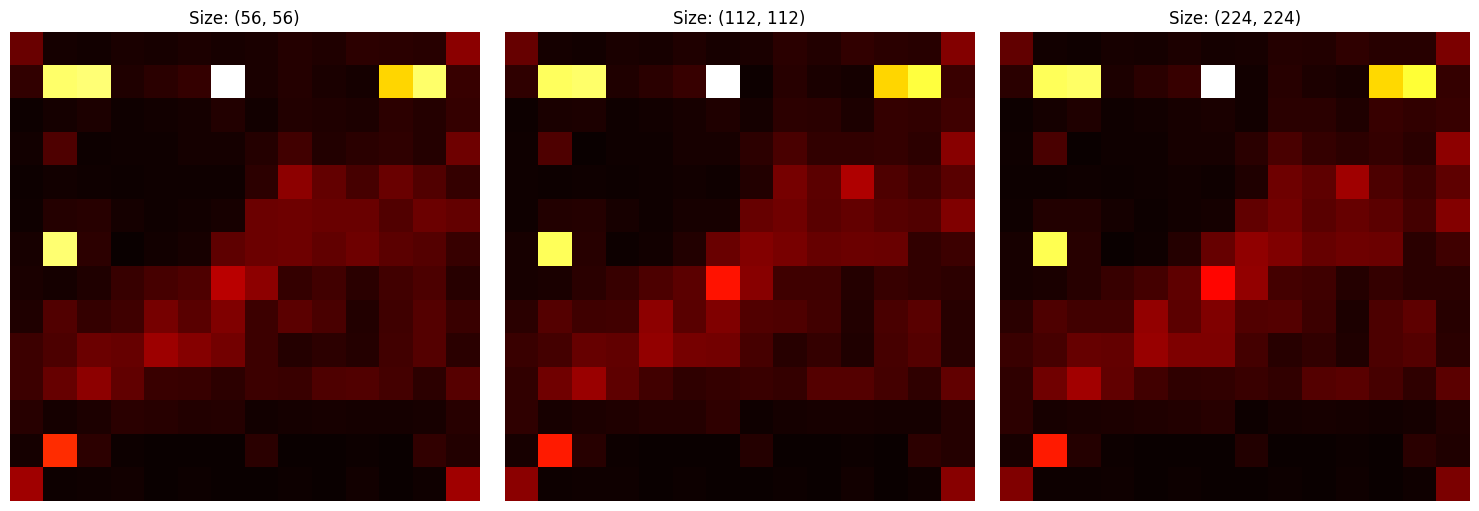

In [7]:
# Тестирование с разными размерами изображений
def test_different_resolutions():
    original_image = test_images[0]
    
    # Разные размеры
    sizes = [(56, 56), (112, 112), (224, 224)]
    
    fig, axes = plt.subplots(1, len(sizes), figsize=(15, 5))
    
    for idx, size in enumerate(sizes):
        # Ресайз изображения
        resized_image = original_image.resize(size)
        
        # Анализ внимания
        attentions, _, _ = analyzer.get_attention_maps(resized_image)
        cls_attention = attentions[-1][0].mean(dim=0)[0, 1:].cpu().numpy()
        
        grid_size = int(np.sqrt(cls_attention.shape[0]))
        attention_map = cls_attention.reshape(grid_size, grid_size)
        
        axes[idx].imshow(attention_map, cmap='hot')
        axes[idx].set_title(f'Size: {size}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('../reports/attention_visualizations/resolution_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

test_different_resolutions()

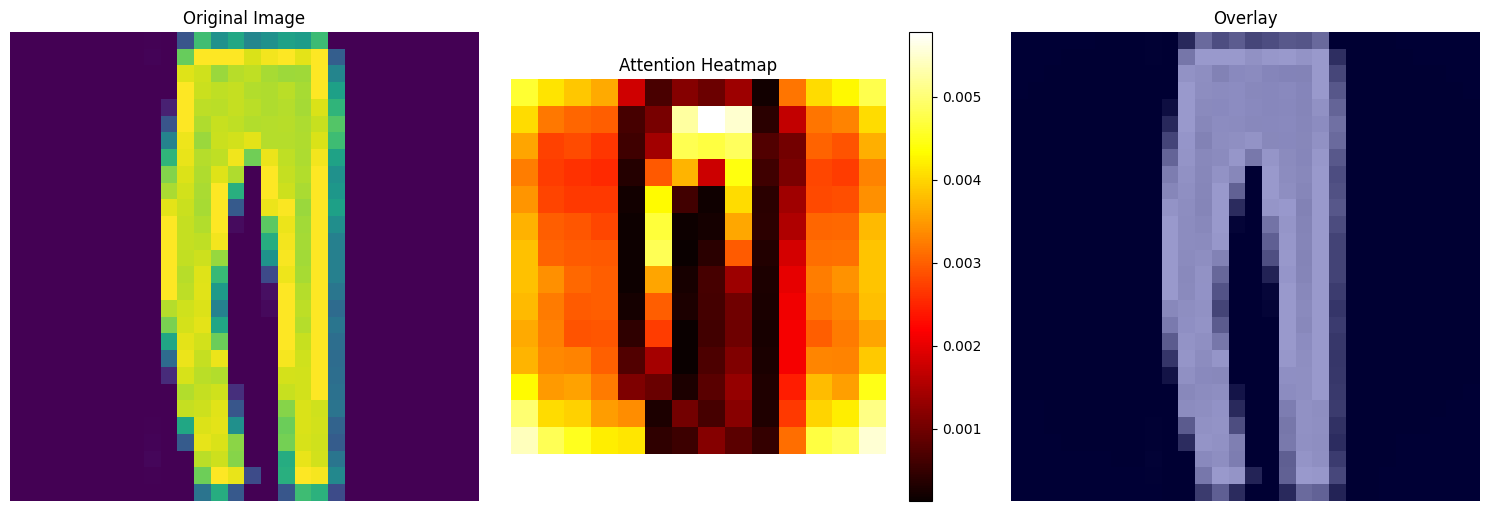

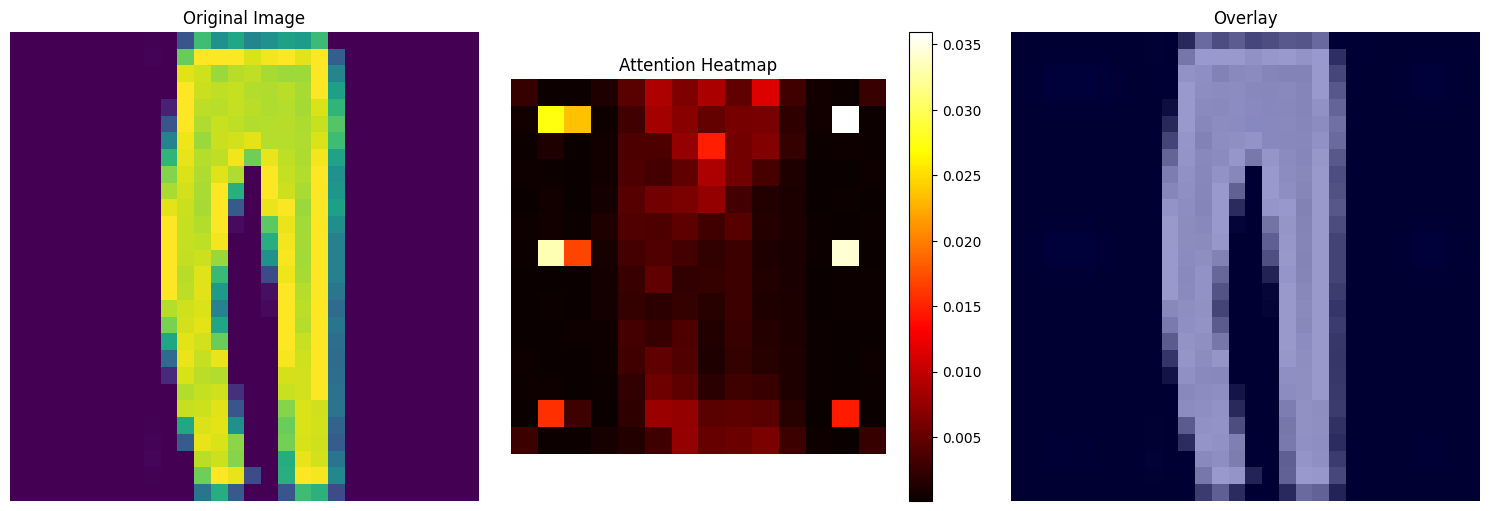

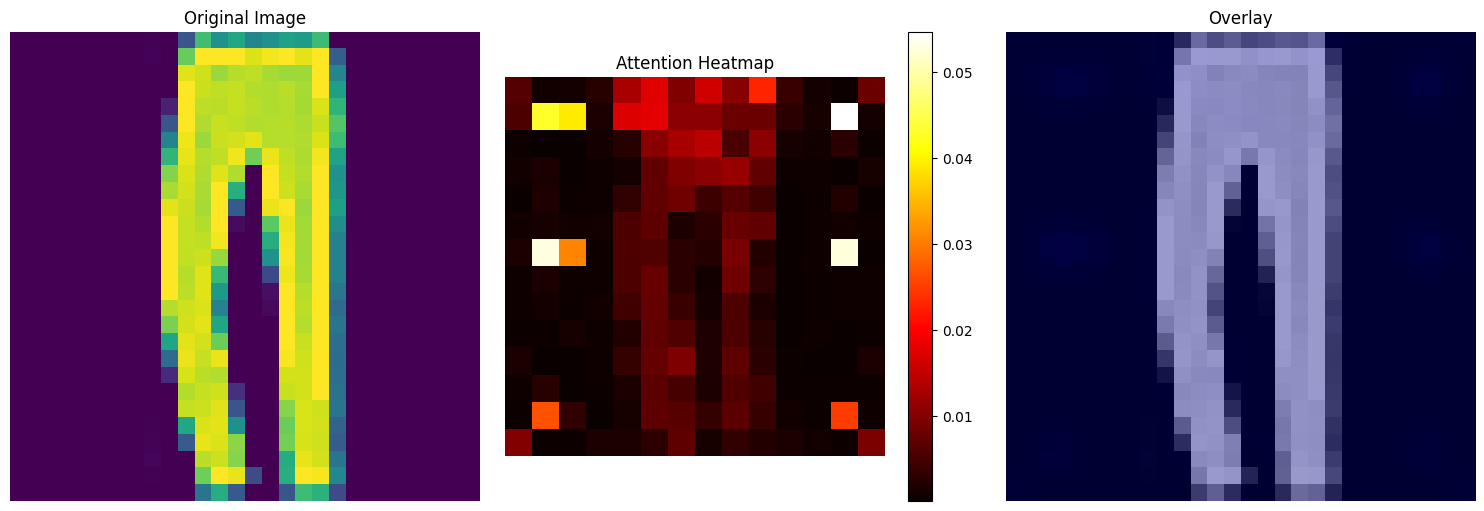

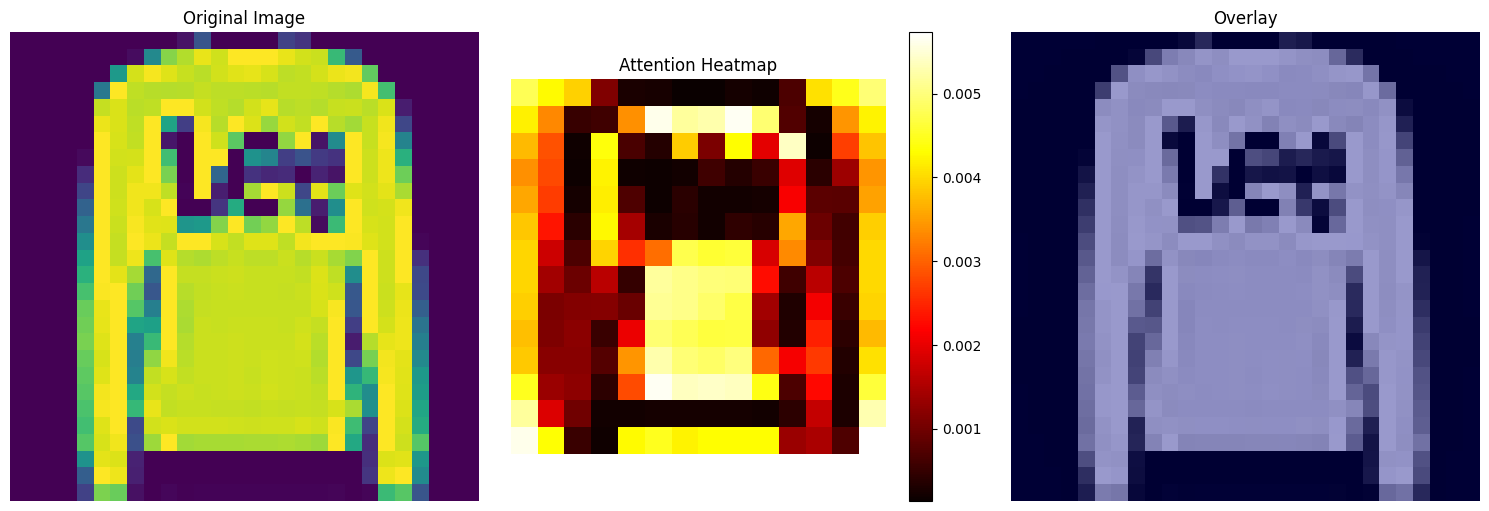

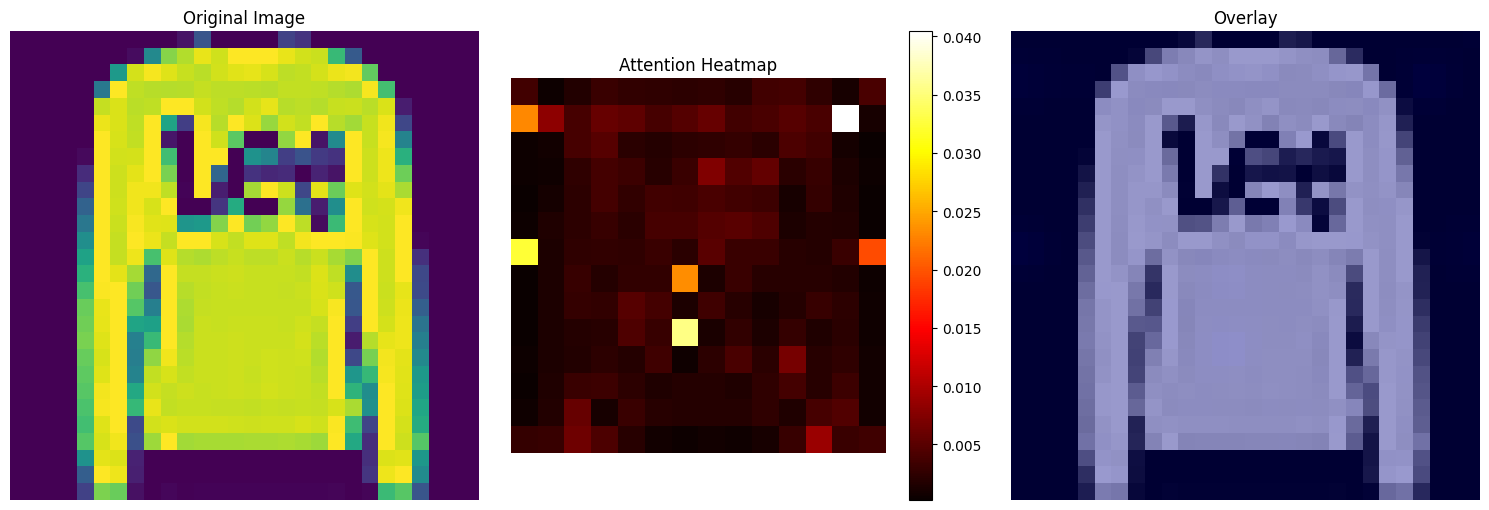

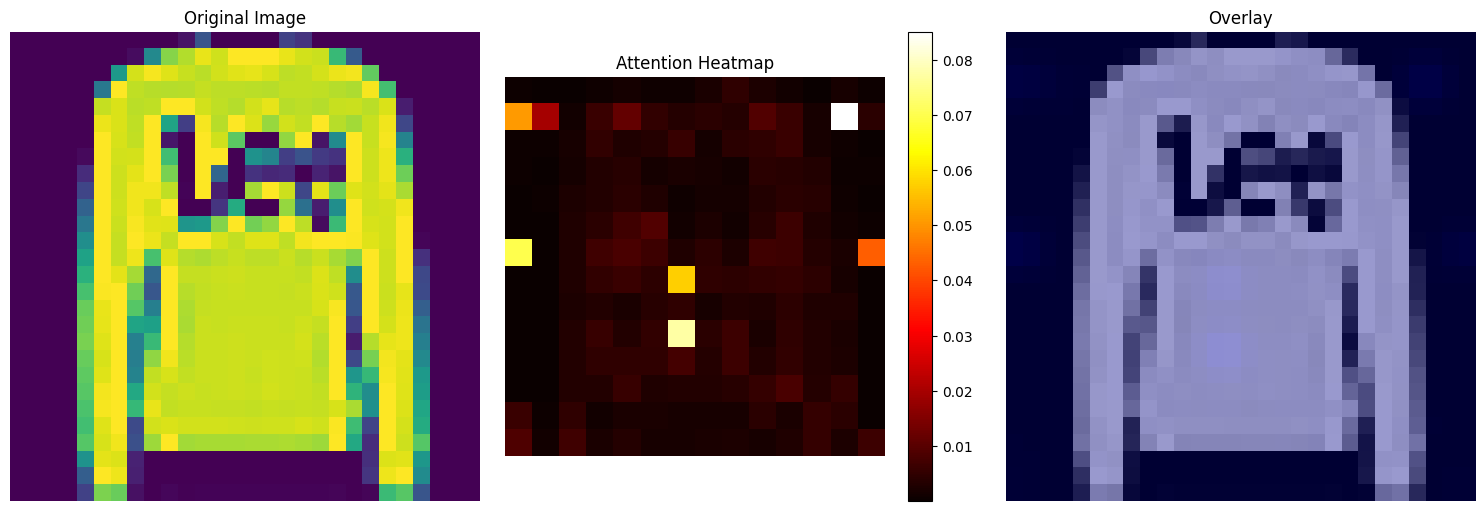

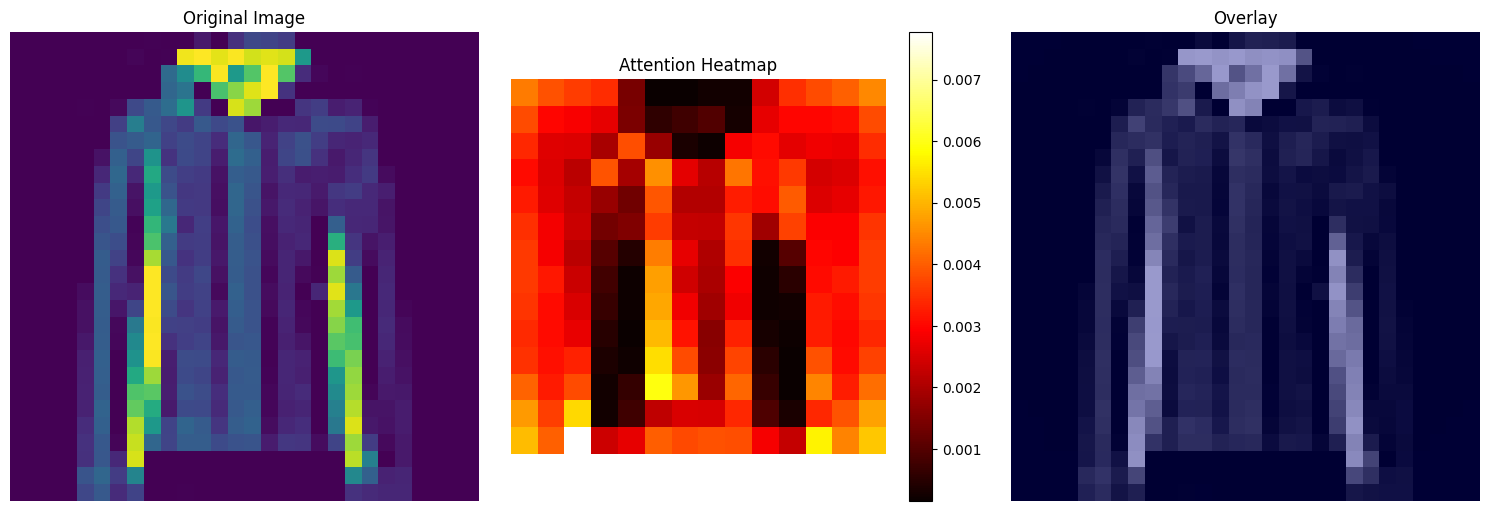

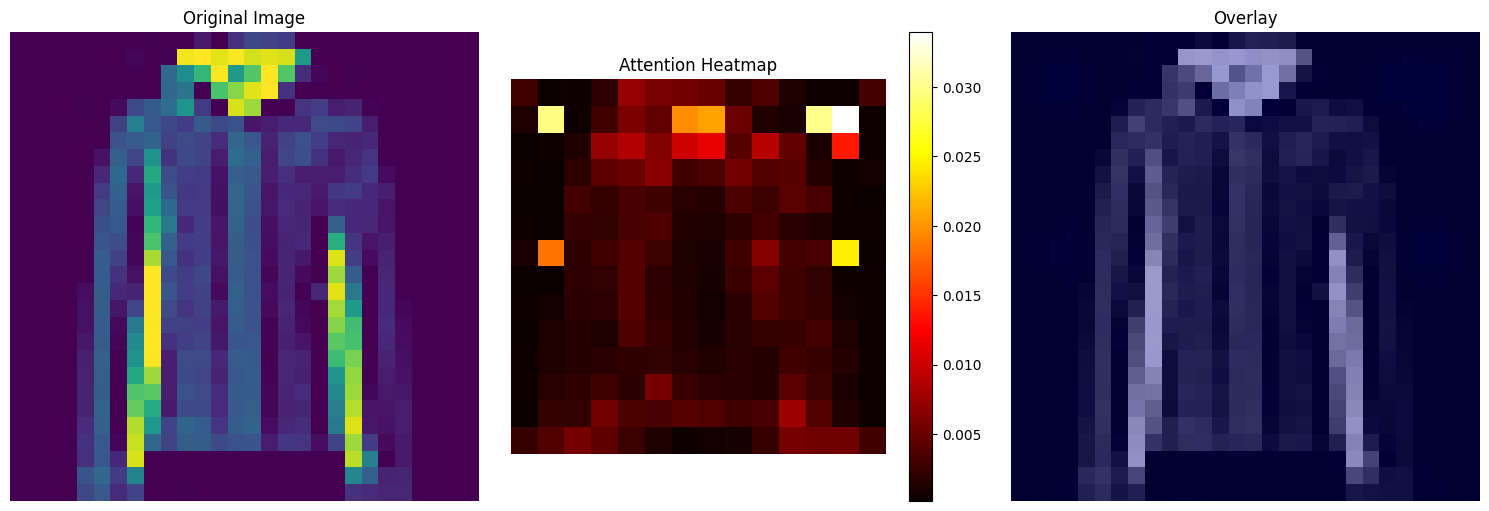

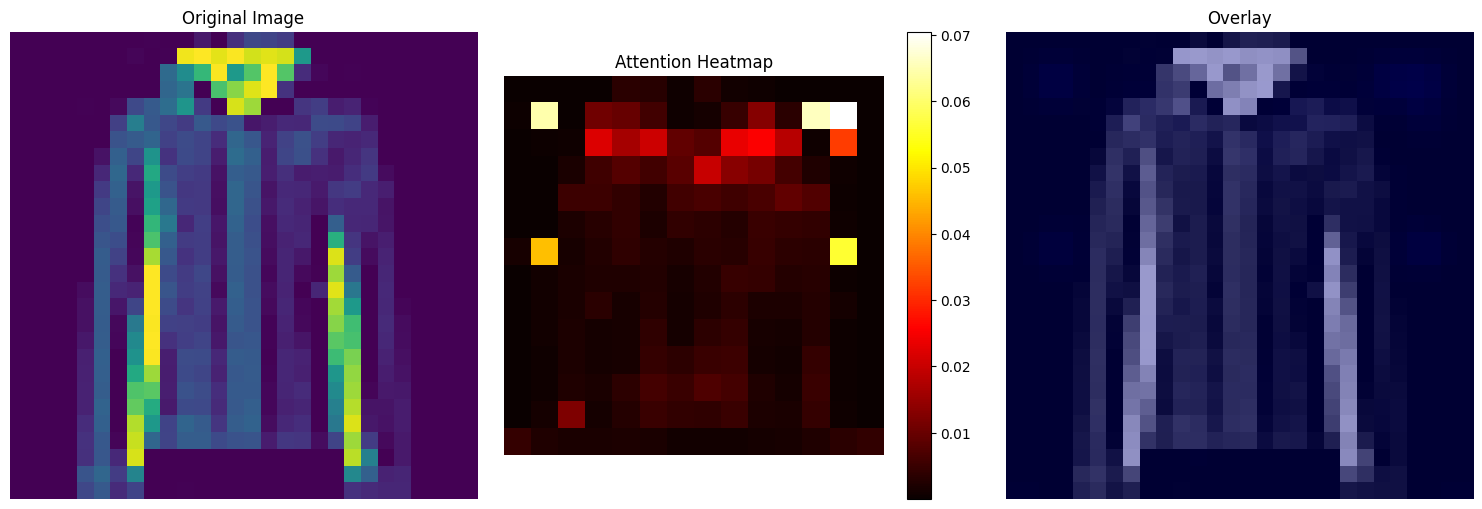

In [11]:
# Анализ attention для разных классов
class_analysis = {}

for class_id in range(5):  # Первые 5 классов
    class_images = [img for img, lbl in zip(test_images, test_labels) if lbl == class_id]
    
    if class_images:
        # Анализ для первого изображения класса
        attention_maps = []
        for layer in [0, 6, 11]:  # Начальный, средний, конечный слои
            fig = analyzer.visualize_cls_attention(
                class_images[0], 
                layer_idx=layer, 
                head_idx=0
            )
            attention_maps.append(fig)
        
        class_analysis[label_names[class_id]] = attention_maps

In [9]:
# Количественные метрики внимания
def calculate_attention_metrics(attention_maps):
    """Вычисление метрик внимания"""
    metrics = {}
    
    # Focus score (насколько внимание сконцентрировано)
    entropy = -torch.sum(attention_maps * torch.log(attention_maps + 1e-8), dim=-1)
    metrics['focus_score'] = 1 - (entropy / np.log(attention_maps.shape[-1]))
    
    # Coverage (сколько патчей охвачено вниманием)
    coverage = (attention_maps > attention_maps.mean()).float().mean(dim=-1)
    metrics['coverage'] = coverage
    
    return metrics

In [10]:
# Применение к тестовым изображениям
for i in range(3):
    attentions, _, _ = analyzer.get_attention_maps(test_images[i])
    
    # Анализ последнего слоя
    last_layer_attention = attentions[-1][0].mean(dim=0)  # Усредняем по головам
    cls_attention = last_layer_attention[0, 1:]
    
    metrics = calculate_attention_metrics(cls_attention.unsqueeze(0))
    
    print(f"Image {i} ({label_names[test_labels[i]]}):")
    print(f"  Focus Score: {metrics['focus_score'].mean().item():.3f}")
    print(f"  Coverage: {metrics['coverage'].mean().item():.3f}")
    print()

Image 0 (Ankle boot):
  Focus Score: 0.170
  Coverage: 0.286

Image 1 (Pullover):
  Focus Score: 0.188
  Coverage: 0.168

Image 2 (Trouser):
  Focus Score: 0.176
  Coverage: 0.301

